# Error analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd

# plot style
sns.set_style('whitegrid')
sns.set_style({'font.family': 'Times New Roman'})

# Load results data

We load results data from the initial re-execution (`df2`) and from the re-execution after code cleaning (`df1`).

In [53]:
df1 = pd.read_csv("data/aggregate_results_env.csv", index_col=0)
df2 = pd.read_csv("data/aggregate_results_no_env.csv", index_col=0)

# Run result frequency

View most frequent errors.

In [34]:
df1['result'].value_counts()

success                                                                                                                                                           1472
Error in readChar(con, 5L, useBytes = TRUE) : cannot open the connection                                                                                           296
Error in file(file, 'rt') : cannot open the connection                                                                                                             237
Error in file(filename, 'r', encoding = encoding) :   cannot open the connection                                                                                    67
Error in makeRestartList(...) : reached elapsed time limit                                                                                                          65
Error in eval(m$data, parent.frame()) : object 'poets' not found                                                                                                    1

In [35]:
df2['result'].value_counts()

success                                                                                                                                                                             952
Error in file(file, 'rt') : cannot open the connection                                                                                                                              128
Error in readChar(con, 5L, useBytes = TRUE) : cannot open the connection                                                                                                            125
Error in library(stargazer) : there is no package called 'stargazer'                                                                                                                 71
Error in library(car) : there is no package called 'car'                                                                                                                             60
Error in library(Hmisc) : there is no package called 'Hmisc'                    

# Error type

The following function (`error_type`) classifies errors according to their type.

In [36]:
def error_type(el):
    if 'success' in el:
        return 'success'
    if 'setwd' in el:
        return 'setwd'
    
    # library
    if 'there is no package' in el:
        return 'library'
    if 'no packages called' in el:
        return 'library'
    if 'could not find function' in el:
        return 'library'
    if 'no library trees found' in el:
        return 'library'
    if 'install.packages' in el:
        return 'library'
    
    #if "unexpected" in el or 'unrecognized' in el:
    #    return 'syntax'
    #if 'RStudio' in el or 'Stata' in el:
    #    return 'RStudio or Stata'
    

    # file, path or output
    if 'cannot open the connection' in el:
        return 'file, path or output'
    if 'does not exist' in el:
        return 'file, path or output'
    if 'No such file or directory' in el:
        return 'file, path or output'
    if 'must already exist' in el:
        return 'file, path or output'
    if 'basename' in el:
        return 'file, path or output'
    if 'cannot open file' in el or 'no device to print' in el:
        return 'file, path or output'
    if 'figure margins' in el or '.pdf' in el:
        return 'file, path or output'
    
    if "object" in el and "not found" in el:
        return "R object not found"
    
    if 'reached elapsed time limit' in el:
        return 'reached time limit'
    else:
        #print el
        return 'other'

We remove entries with no results:

In [56]:
df1 = df1[df1['result'].notna()]
df2 = df2[df2['result'].notna()]

In [12]:
# remove success
df1 = df1[df1['result']!='success']
df2 = df2[df2['result']!='success']

In [24]:
pd.options.display.max_colwidth = 300

In [63]:
print(len(df1[df1.result.str.contains("pdf(", regex=False)].result))
print(len(df1[df1.result.str.contains("jpeg(", regex=False)].result))
print(len(df1[df1.result.str.contains("postscript(", regex=False)].result))
print(len(df1[df1.result.str.contains("png(", regex=False)].result))
print(len(df1[df1.result.str.contains("tiff(", regex=False)].result))
print(len(df1[df1.result.str.contains("save(", regex=False)].result))
print(len(df1[df1.result.str.contains("write.csv(", regex=False)].result))

40
1
1
0
0
0
0


In [39]:
df1.result.str.contains("Error in source(r_file)", regex=False).sum()

5

In [40]:
df1 = df1[~df1.result.str.contains("Error in source(r_file)", regex=False)]
df2 = df2[~df2.result.str.contains("Error in source(r_file)", regex=False)]

In [41]:
df1['error_type']=df1['result'].apply(error_type)
df2['error_type']=df2['result'].apply(error_type)

df2['error_type'].value_counts()

library                 1846
file, path or output     386
setwd                    361
R object not found       184
other                     54
reached time limit        10
Name: error_type, dtype: int64

# Constructing Sankey

The Sankey plot (Fig. 8) shows the distribution of error types before and after code cleaning.
First, we match the results of specific R scripts to understand how it performed before and after code cleaning:

In [42]:
df = pd.merge(df1, df2, on=['doi','file'], how='outer')

Second, we remove NAs:

In [43]:
df = df[df['result_x'].notna()]
df = df[df['result_y'].notna()]

In [44]:
len(df)

1224

Then, we classify all errors by type:

In [45]:
df['type_x'] = df['result_x'].apply(error_type)
df['type_y'] = df['result_y'].apply(error_type)

In [46]:
len(df[(df['success_y'] == 1)])

0

Last, we count values for each error type:

In [47]:
df['type_y'].value_counts()

library                 680
file, path or output    225
setwd                   159
R object not found      121
other                    37
reached time limit        2
Name: type_y, dtype: int64

In [48]:
df[(df['type_y'] == 'other')]['type_x'].value_counts()

other                 35
reached time limit     1
library                1
Name: type_x, dtype: int64

## Sanky result

To be plotted at: http://sankeymatic.com/build/

```
R files [843] Success #00CC00
R files [850] Library Error #0033cc
R files [221] SetWD #cc00cc
R files [229] File, Path or Output Error #cc0033
R files [136] R Object Not Found #cccc00
R files [56] Other Error #cc6600

Library Error [170] Success #00CC00
Library Error [429] Library  Error #0033cc
Library Error [175] File, Path or Output  Error #cc0033
Library Error [20] R Object Not  Found #cccc00
Library Error [56] Other  Error #cc6600

File, Path or Output Error [4] Success #00CC00
File, Path or Output Error [218] File, Path or Output  Error #cc0033
File, Path or Output Error [3] Library  Error #0033cc
File, Path or Output Error [1] R Object Not  Found #cccc00
File, Path or Output Error [3] Other  Error #cc6600

R Object Not Found  [15] Success #00CC00
R Object Not Found [1] Library  Error #0033cc
R Object Not Found [1] File, Path or Output  Error #cc0033
R Object Not Found [118] R Object Not  Found #cccc00
R Object Not Found [1] Other  Error #cc6600

Other Error [3] Success #00CC00
Other Error [4] Library  Error #0033cc
Other Error [4] File, Path or Output  Error #cc0033
Other Error [2] R Object Not  Found #cccc00
Other Error [43] Other  Error #cc6600

SetWD [62] Success #00CC00
SetWD [59] Library  Error #0033cc
SetWD [72] File, Path or Output  Error #cc0033
SetWD [10] R Object Not  Found #cccc00
SetWD [18] Other  Error #cc6600
```

# Error percentages 

Calculate percentage of each error type (before and after code cleaning):

In [49]:
(df1['error_type'].value_counts(normalize=True) * 100).round(2).sort_index()

R object not found      10.01
file, path or output    41.84
library                 38.14
other                    6.45
reached time limit       3.52
success                  0.05
Name: error_type, dtype: float64

In [50]:
len(df1)

2218

In [51]:
(df2['error_type'].value_counts(normalize=True) * 100).round(2).sort_index()

R object not found       6.48
file, path or output    13.59
library                 64.98
other                    1.90
reached time limit       0.35
setwd                   12.71
Name: error_type, dtype: float64

In [52]:
len(df2)

2841

# Bar plot

The following explores other types of result visualization. 

[Text(0,0,'library'),
 Text(0,0,'R object not found'),
 Text(0,0,'file, path or output'),
 Text(0,0,'other'),
 Text(0,0,'reached time limit'),
 Text(0,0,'success')]

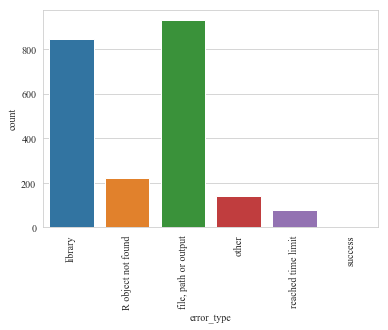

In [53]:
ax = sns.countplot(x="error_type", data=df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'setwd'),
 Text(0,0,'library'),
 Text(0,0,'file, path or output'),
 Text(0,0,'R object not found'),
 Text(0,0,'other'),
 Text(0,0,'reached time limit')]

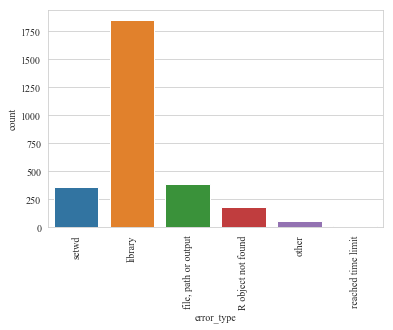

In [54]:
ax = sns.countplot(x="error_type", data=df2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Compare

In [55]:
# new temp dataframe
d = {'error_type': df1['error_type']}
df = pd.DataFrame(data=d)

In [56]:
df['origin']='after code cleaning'
df.head()

,error_type,origin
2,library,after code cleaning
5,R object not found,after code cleaning
8,"file, path or output",after code cleaning
9,library,after code cleaning
10,library,after code cleaning


In [57]:
temp = pd.DataFrame(data={'error_type': df2['error_type']})
temp['origin']='before code cleaning'
temp.head()

,error_type,origin
45,setwd,before code cleaning
46,library,before code cleaning
47,"file, path or output",before code cleaning
48,"file, path or output",before code cleaning
49,"file, path or output",before code cleaning


In [58]:
df = temp.append(df)

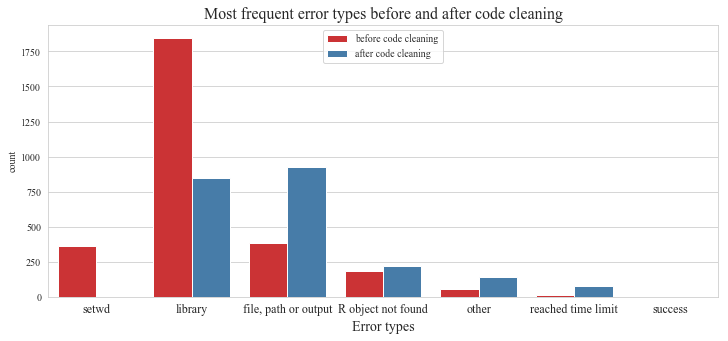

In [59]:
plt.figure(figsize=(12,5))

ax = sns.countplot(x="error_type", hue='origin', data=df, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=0)
ax.set_title("Most frequent error types before and after code cleaning", fontsize=16)
ax.set_xlabel("Error types", fontsize=14)

plt.legend(title='')

plt.savefig('plots/error_types.png', bbox_inches = "tight")